## Generates H5 files and wont run the model again if the file exists

/var/folders/fn/1jtndfnx627f_ntlsfhq1d8r0000gn/T/ipykernel_42903/679829176.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stock_data = pd.read_sql(query, conn)


Training new model...
Epoch 1/50


2025-03-10 12:26:02.823040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-10 12:26:02.823850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-10 12:26:02.824529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/30 [==============================] - 2s 19ms/step - loss: 0.0216
Epoch 2/50
30/30 [==============================] - 1s 18ms/step - loss: 0.0041
Epoch 3/50
30/30 [==============================] - 1s 19ms/step - loss: 0.0029
Epoch 4/50
30/30 [==============================] - 1s 19ms/step - loss: 0.0021
Epoch 5/50
30/30 [==============================] - 1s 19ms/step - loss: 0.0020
Epoch 6/50
30/30 [==============================] - 1s 20ms/step - loss: 0.0020
Epoch 7/50
30/30 [==============================] - 1s 19ms/step - loss: 0.0019
Epoch 8/50
30/30 [==============================] - 1s 19ms/step - loss: 0.0019
Epoch 9/50
30/30 [==============================] - 1s 19ms/step - loss: 0.0017
Epoch 10/50
30/30 [==============================] - 1s 19ms/step - loss: 0.0017
Epoch 11/50
30/30 [==============================] - 1s 19ms/step - loss: 0.0017
Epoch 12/50
30/30 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 13/50
30/30 [=============================

2025-03-10 12:26:33.163526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-10 12:26:33.164002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-10 12:26:33.164674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 0s 5ms/step


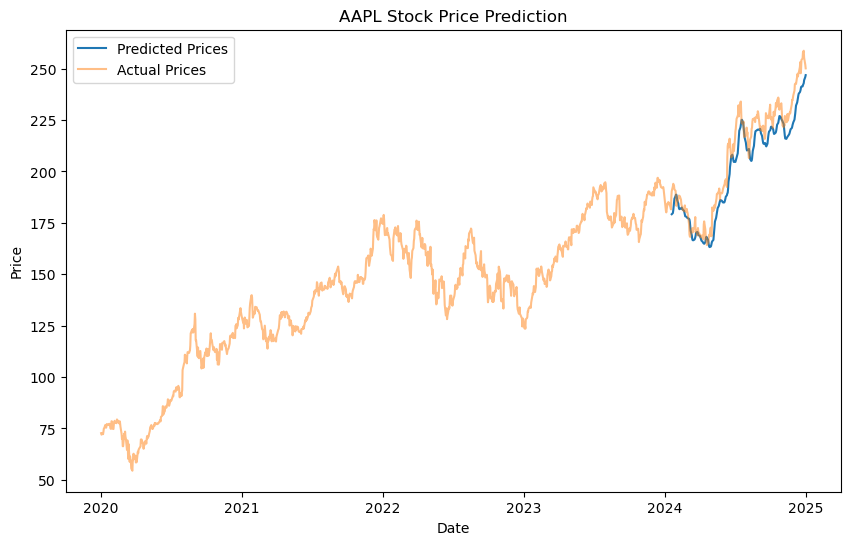

In [6]:
import os
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from credentials import ipCred, usernameCred, passwordCred, databaseCred

def run_lstm_for_ticker():
    """
    Prompts the user for a ticker symbol, queries the corresponding
    MySQL table, loads or trains an LSTM model, and plots the predictions.
    """
    
    # 1. Get ticker from user
    ticker = input("Enter the ticker symbol (e.g., AAPL, ORCL): ").strip().upper()
    
    # 2. Database connection parameters
    db_config = {
        'host': ipCred,
        'user': usernameCred,
        'password': passwordCred,
        'database': databaseCred
    }

    # 3. Establish connection and build the query dynamically
    conn = mysql.connector.connect(**db_config)
    query = f"""
        SELECT date, close
        FROM {ticker}_data
        WHERE date BETWEEN '2020-01-01' AND '2025-01-01'
        ORDER BY date ASC;
    """
    
    # 4. Read the query results into a DataFrame
    stock_data = pd.read_sql(query, conn)
    conn.close()

    # 5. Convert date column to datetime and set it as the index
    stock_data['date'] = pd.to_datetime(stock_data['date'])
    stock_data.set_index('date', inplace=True)

    # 6. Use the 'close' column for modeling
    closing_prices = stock_data[['close']]

    # 7. Normalize the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(closing_prices)

    # 8. Create the dataset for training
    def create_dataset(data, time_step=60):
        X, Y = [], []
        for i in range(len(data) - time_step - 1):
            X.append(data[i:(i+time_step), 0])
            Y.append(data[i+time_step, 0])
        return np.array(X), np.array(Y)

    time_step = 60
    X, Y = create_dataset(scaled_data, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # 9. Split data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    Y_train, Y_test = Y[:train_size], Y[train_size:]

    # 10. Define the model file name
    model_filename = f"{ticker}_lstm_model.h5"

    # 11. Load model if it exists; otherwise, build and train
    if os.path.exists(model_filename):
        print(f"Loading model from {model_filename}...")
        model = load_model(model_filename)
    else:
        print("Training new model...")
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X_train, Y_train, epochs=50, batch_size=32)
        # Save the trained model
        model.save(model_filename)
        print(f"Model saved as {model_filename}")

    # 12. Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

    # 13. Plot results
    plt.figure(figsize=(10,6))
    # Adjust the starting index to account for the time steps offset
    plt.plot(stock_data.index[train_size+time_step+1:], predictions, label="Predicted Prices")
    plt.plot(stock_data.index, stock_data['close'], label="Actual Prices", alpha=0.5)
    plt.title(f"{ticker} Stock Price Prediction")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    run_lstm_for_ticker()